## Gera  kmls separados por status

#### Parametros de teste

In [ ]:
gera_shp=True

In [ ]:
tipo='Status GPD'
tipo='Status Parcial'

#### Gera kml

In [ ]:
from arcgis.gis import GIS
gis = GIS("home")

In [ ]:
def retorna_posicao(lista,elemento):
    """
    Retorna a posicao de um elemento em uma lista de objetos
    """
    for i in range(len(lista)):
        mapa=str(lista[i])
        split=mapa.replace('"','').replace(' type','').split(':')[1]
        if(split==elemento):
            return i 

In [ ]:
def retorna_df_areas_projetos(projetos):
    dict_layer = {}
    for projeto in projetos:
        map_projeto = gis.content.search('title:' + projeto, 'Feature Layer')
        Projeto_item = map_projeto[retorna_posicao(map_projeto, projeto)]
        Projeto_layers = Projeto_item.layers
        Projeto_tables = Projeto_item.tables
        dict_layer[projeto]={}
        for layer in Projeto_layers:
            lyr_fset = layer.query()
            lyr_sdf = lyr_fset.sdf
            dict_layer[projeto][layer.properties.name]={'sublayer': layer, 'sdf': lyr_sdf}
    return dict_layer

In [ ]:
from arcgis.geometry import lengths, areas_and_lengths, project
import pandas as pd
def reproject_sdf(sdf,epsg):
    if(epsg==3857):
        out_SR={'wkid': 102100, 'latestWkid': 3857}
    if(epsg==4326):
        out_SR={'wkid': 4326}
    result = project(
        geometries=list(sdf['SHAPE']),
        in_sr=sdf.spatial.sr,
        out_sr=out_SR
    )

    sdf_reprojetado = pd.DataFrame(columns=sdf.columns)

    for col in list(sdf):
        if col != "SHAPE":
            sdf_reprojetado.loc[:, col] = sdf[col].values

    for i, row in sdf_reprojetado.iterrows():
        sdf_reprojetado.at[i, 'SHAPE']  = result[i]
        
    # Define a coluna "SHAPE" como coluna espacial do DataFrame
    sdf_reprojetado.spatial.set_geometry('SHAPE', inplace=True)
    return sdf_reprojetado

In [ ]:
#Retorna o dicionario contendo as infos de todos os layers
dict_layers=retorna_df_areas_projetos(projetos)

### Funcoes de atuacao nos mapas

#### Funcoes para fazer o XML

In [ ]:
from cmath import nan
import pandas as pd
import lxml.etree as ET
from lxml.builder import ElementMaker
from xml.dom import minidom
import xlrd 
import math
import time
import locale
import os 

def makeSimpleFieldSchema(name, text):
        simplefield = ET.Element('SimpleField')
        simplefield.set('type', 'string')
        simplefield.set('name', name)
        ET.SubElement(simplefield, 'displayName').text = text
        return simplefield
# Cria a legenda com o link fixo
def makeLegenda():
    return ET.fromstring('<ScreenOverlay><name>LEGENDA</name><open>1</open><Icon><href>https://i.ibb.co/DLTttZg/Legenda-v2.png</href></Icon><overlayXY x="0" y="0" xunits="fraction" yunits="fraction"/><screenXY x="30" y="50" xunits="pixels" yunits="pixels"/><rotationXY x="0.5" y="0.5" xunits="fraction" yunits="fraction"/><size x="0" y="0" xunits="pixels" yunits="pixels"/></ScreenOverlay>')

# Cria uma pasta
def makeFolder(folderName):
    folder = ET.Element('Folder')
    name = ET.SubElement(folder, 'name').text = folderName
    return folder

#modifica as coordenadas para ficar no padrao que seja aceitado pelo kml
def normalizeCoords(coords):
    coords = coords.strip('[]')
    coords = coords.split(",")
    final = []
    for i in range(0, len(coords), 2):
        final.append(coords[i].strip(' ()') + "," + coords[i+1].strip(' ()')+",0")
    s = "\n"
    return s.join(final)


In [ ]:
# Cria os estilos (ballão, cores de linha e cor do poligono)
def makeStyle(idStyle, lineStyleSpecs, polyStyle):
    style = ET.Element('Style')
    style.set('id', idStyle)
    BalloonStyle = ET.SubElement(style, 'BalloonStyle')
    text = ET.SubElement(BalloonStyle, 'text')
    
    #Monta mtl_template com as colunas desejadas
    html_template = '<table border="0">'
    for label, key,column in dicionario:
        html_template += f'<tr><td><b>{label}</b></td><td>$[teste/{key}]</td></tr>'
    html_template += '</table>'
    text.text = ET.CDATA(html_template)
    
    linestyle = ET.SubElement(style, 'LineStyle')
    if lineStyleSpecs['width'] != None:
        ET.SubElement(linestyle, 'width').text = lineStyleSpecs['width']
    if lineStyleSpecs['color'] != None:
        ET.SubElement(linestyle, 'color').text = lineStyleSpecs['color']
    polystyle = ET.SubElement(style, 'PolyStyle')
    ET.SubElement(polystyle, 'color').text = polyStyle['color']
    return style

# Cria a marcação do poligono com os dados e estilo
def makePlacemark (dados, style):
    placemark = ET.Element('Placemark')
    ET.SubElement(placemark, 'name').text = dados["# Área"]
    ET.SubElement(placemark, 'styleUrl').text = '#'+style
    extendedData = ET.SubElement(placemark, 'ExtendedData')
    schemaData = ET.SubElement(extendedData, 'SchemaData')
    schemaData.set('schemaUrl', '#S_teste_SSSSSD')
    
    simpledata = ET.SubElement(schemaData, 'SimpleData')
    for label, key,column in dicionario:
        if(column!=''):
            simpledata.set('name', key)
            simpledata.text = str(dados[column]) if str(dados[column]) != 'nan' else ""
            simpledata = ET.SubElement(schemaData, 'SimpleData')
    
    polygon = ET.SubElement(placemark, 'Polygon')
    outerboundaryis = ET.SubElement(polygon, 'outerBoundaryIs')
    lineraring = ET.SubElement(outerboundaryis, "LinearRing")
    coordinates = ET.SubElement(lineraring, 'coordinates')
    coordinates.text = normalizeCoords(str(dados['Coordenadas']))

    return placemark

### Variaveis

#### funcoes mutaveis

### Trabalho com dataframe

In [ ]:
   dicionario = [
    ('Área', 'AREA','# Área'),
    ('Proprietário', 'PROPRIETARIO','Proprietario_principal'),
    ('Matrícula', 'MATRICULA','Matricula'),
    ('Contrato', 'CONTRATO','Contrato'),
    ('Area (ha)', 'AREA_UTM','Área (ha) - matrícula'),
    ('Nome Imovel', 'NOME_IMOVEL','Imovel'),
     ('Status','STATUS','Status')  
    ]

In [ ]:
def coordenadas(pontos_arcgis):
    # Extrair as coordenadas dos pontos
    coordenadas = pontos_arcgis['rings'][0]
    # Criar a lista de tuplas no formato do shapefile.Reader
    pontos_shapefile = [(coord[0], coord[1]) for coord in coordenadas]

    return pontos_shapefile

 -O formato esperado pra montar as pastas e subpastas e um formato hierarquico onde o numero na coluna revela a pasta e subpasta daquele item , veja o exemplo abaixo:
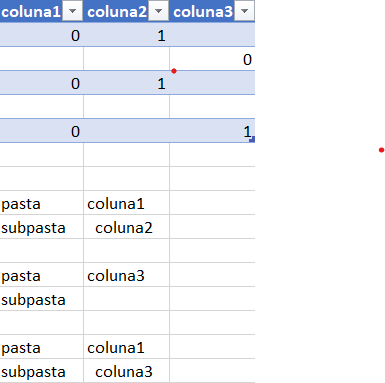
 -Dessa forma e necessario transformar o dataframe nesse molde com o molde de coodenadas no formato [(x1,y1),(x2,y2)...] 
 -E preciso montar um dict de estilos de tuple onde o tuple contem o nome das pastas e subpastas e o element,idcolor... contem os itens da pasta de nivel mais alto

In [ ]:
dict_makestyle=[{'name': "CONCORRENTES", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'660d00fc'},'element': []}},
{'name': "SUJEITA À DISTRATO", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ff00ffff"}, 'polyStyle':{'color':'99898988'}},'element': []},
{'name': "DISTRATADA", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'66000000'}},'element': []},
{'name': "MAPEADO SEM DOCUMENTOS", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'6600ffff'}},'element': []},
{'name': "MAPEADO COM DOCUMENTOS", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'660055ff'}},'element': []},
{'name': "ÁREAS CTG", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'ccffffff'}},'element': []},
{'name': "CONTRATADO SEM MATRÍCULA", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'66ffff00'}},'element': []},
{'name': "PROTOCOLADO CORREDOR DE VENTOS", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'66ffcf30'}},'element': []},
{'name': "CONTRATADO COM MATRÍCULA EM NOME DE 3º", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'66ffa855'}},'element': []},
{'name': "CONTRATADO COM MATRÍCULA EM NOME DO PROPRIETÁRIO", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'66ff0000'}},'element': []},
{'name': "CONTRATADO COM MATRÍCULA E COM GEO INCRA", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'66ff00aa'}},'element': []},
{'name': "CONTRATADO COM MATRÍCULA RETIFICADA E COM GEO INCRA", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': "ffffffff"}, 'polyStyle':{'color':'667f00aa'}},'element': []},
{'name': "REGULARIZADO", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': 'ffffffff'}, 'polyStyle':{'color':'6600aa00'}},'element': []},
{'name': "REGULARIZADO PADRÃO INTERNACIONAL", 'idColor':None, 'colors':{'lineStyle':{'width': '2', 'color': 'ffffffff'}, 'polyStyle':{'color':'6600aa00'}},'element': []},
{'name': 'APROVADO', 'idColor': None, 'colors': {'lineStyle': {'width': '2', 'color': 'ffffffff'}, 'polyStyle': {'color': '6600aa00'}}, 'element': []},
{'name': 'DESAPROVADO','idColor': None, 'colors': {'lineStyle': {'width': '2', 'color': 'ffffffff'}, 'polyStyle': {'color': '66ff0000'}},'element': []}]


O formato de dict usado em style , pra criar os folders/subfolders e para fazer o Placemark deve ser feito no formato:
dict[item] , onde:
item = {'name': '','idColor': None, 'colors': {'lineStyle': {'width': '', 'color': ''}, 'polyStyle': {'color': ''}},'element': [] (vazio)}

'name':nome do item ,geralmente nome da pasta principal  

'idColor':Para identificar em relacao ao makeStyle

'colors': cor do poligono 'polyStyle' e cor da linha 'lineStyle', geralmente dada pela pasta mas pode ser definidas por subpastas tambem

'element': defult vazio , serve para capturar os elements de placemark , folder .... e inserir no XML


In [ ]:
def retorna_dict_style(dict_makestyle,df):
    col_dict = {}
    for item in dict_makestyle:
        name = item['name']
        if name in df.columns:
                col_dict[(name,)] = {'name': item['name'] , 'idColor':  item['name'], 'colors': item['colors'],'element':[]}
            
    for index, row in df.iterrows():
        possui_topografia = row['SEM TOPOGRAFIA']
        concorrente=row['Concorrente_contratante']
        if isinstance(possui_topografia, (int, float)):
            (principal_folder,coluna)=(row['Status'],row['Status']) if row['Status']!='' else (row['Concorrente_contratante'],'CONCORRENTES')
            if(coluna!='CONCORRENTES'):
                col_dict[(principal_folder , 'SEM TOPOGRAFIA')] = {'name': principal_folder + '_sem_topo', 'idColor': principal_folder + '_sem_topo','colors': {'lineStyle':{'width':'2', 'color': 'FF000000'},'polyStyle':col_dict[(coluna,)]['colors']['polyStyle']},'element':[]}
            else:
                col_dict[("CONCORRENTES",principal_folder , 'SEM TOPOGRAFIA')] = {'name': principal_folder + '_sem_topo', 'idColor': principal_folder + '_sem_topo','colors': {'lineStyle':{'width':'2', 'color': 'FF000000'},'polyStyle':col_dict[(coluna,)]['colors']['polyStyle']},'element':[]}

        if isinstance(concorrente, str) and concorrente!='':
            col_dict[("CONCORRENTES",concorrente)] = {'name': concorrente , 'idColor': concorrente,'colors': {'lineStyle':col_dict[("CONCORRENTES",)]['colors']['lineStyle'],'polyStyle':col_dict[("CONCORRENTES",)]['colors']['polyStyle']},'element':[]}


    # Imprimir o novo dicionário
    return col_dict

In [ ]:
def cria_kmz(df,codigo_projeto,path_kmz):
    # Cria cabeçalho de especificação KML
    orig_xml = '<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom"></kml>'
    kml = ET.fromstring(orig_xml)

    # Cria root e configurações basicas do documento 
    document = ET.SubElement(kml, "Document")
    ET.SubElement(document, "name").text = projeto
    ET.SubElement(document, "open").text = "1"

    # Cria o SCHEMA do Balão
    schema = ET.SubElement(document, 'Schema')
    schema.set('name', 'teste')
    schema.set('id', 'S_teste_SSSSSD')
   
    
    #cria schema de label 
    for label, key,column in dicionario:
        schema.append(makeSimpleFieldSchema(label,"&lt;b&gt;" + label+ "&lt;/b&gt;"))
   
    #Cria o estilo no document
    dict_estilo=retorna_dict_style(dict_makestyle,areas)
    for item in dict_estilo.items():
        key, value = item
        idColor = value['idColor']
        estilo_linha=value['colors']['lineStyle']
        estilo_poligono=value['colors']['polyStyle']
        document.append(makeStyle(idColor, estilo_linha, estilo_poligono)),
        
        #Faz a pasta de nivel mais alto no dict , ou seu o ultimo nivel de subpasta
        folder=makeFolder(key[len(key)-1])
        dict_estilo[key]['element']=folder
    #print(dict_estilo)
    #Organiza o dict conforme o tamanho do tuple
    dict_folders = dict(sorted(dict_estilo.items(), key=lambda x: len(x[0])))
    #print(dict_folders)
    #iterage linha a linha e captura o tuple correspondente na chave
    for chave in dict_folders.keys():
        if(len(chave)==1 and chave[0]!='CONCORRENTES'): #conconrrentes e usado pra pasta posteriormente , isso evitara duplicidade
            data = df[df[chave[0]].notna()].to_dict('index')
            for row in data:
                #if(data[row]['# Área']=='PROP-VCH-0067'):
                #print(chave)
                    numeric_dict = {key: value for key, value in data[row].items() if isinstance(value, (int, float)) and not np.isnan(value)}
                    positional_list = tuple(sorted(numeric_dict, key=numeric_dict.get))
                    estilo = dict_folders.get(positional_list)
                    placemark=makePlacemark(data[row], estilo['idColor'])
                    dict_folders[positional_list]['element'].append(placemark)
                
    #faz o append de subpastas nas pastas acima delas com os elements correspondentes
    for chave in dict_folders.keys():
        if(len(chave)>1):
            dict_estilo[chave[:-1]]['element'].append(dict_estilo[chave]['element'])
            
    #faz o append de element de cada dict no documento            
    for chave in dict_folders.keys():
        if(len(chave)==1):
            document.append(dict_estilo[chave]['element'])
    # salva o arquivo kmz de acordo com o nome do arquivo de entrada e a data de hoje
    tree = ET.ElementTree(kml)
    tree.write(path_kmz)

    print('Arquivo gerado com sucesso!')
    print(path_kmz)

In [ ]:
import numpy as np

def organiza_dados(areas):
    import warnings

    # Ignorar todos os avisos do pandas
    warnings.filterwarnings("ignore")

    areas=areas[['area_code','Proprietario_principal','Imovel','Status','Matricula','ID_Creator','ID_Editor','Contrato','Possui_topografia','Concorrente_contratante',"SHAPE"]]
    areas['SHAPE'] = areas['SHAPE'].apply(lambda x: coordenadas(x))
    areas['Área (ha) - matrícula']= [np.nan]*len(areas)
    

    # Converter valores da coluna 'status' para letras maiúsculas
    areas.loc[:,'Status'] = areas['Status'].str.upper()

    # Obter lista de valores únicos da coluna 'status'
    status_unique = areas['Status'].drop_duplicates().tolist()
    
    #concorrentes_unique = list(filter(lambda x: x != '', concorrentes_unique))
    
    areas['Status'] = areas['Status'].fillna('')
    areas['Concorrente_contratante'] = areas['Concorrente_contratante'].fillna('')
    areas['Possui_topografia'] = areas['Possui_topografia'].fillna('')

    
    areas['Possui_topografia'] = areas.apply(lambda x: 
    (2 if x['Possui_topografia'] == 'SEM TOPOGRAFIA' and x['Concorrente_contratante'] != '' 
     else 1 if x['Possui_topografia'] == 'SEM TOPOGRAFIA' and x['Status']!=''
     else np.nan), axis=1)
    # garante que concorremtes nao tem status
    areas.loc[areas['Concorrente_contratante']!='', 'Status'] = ''

    # Preencher as colunas de status com 0 para os valores correspondentes
    for status in status_unique:
        areas.loc[:,status] = areas['Status'].apply(lambda x: 0 if x == status else np.nan)
    concorrentes_unique = areas['Concorrente_contratante'].unique().tolist()
    # Preencher as colunas de status com 'SIM' para os valores correspondentes
    for concorrente in concorrentes_unique:
        if(concorrente!=''):
            areas.loc[:,concorrente] = areas['Concorrente_contratante'].apply(lambda x: 1 if x == concorrente  else np.nan)
    areas['CONCORRENTES'] = areas['Concorrente_contratante'].apply(lambda x: 0 if x != '' else '')
    
    #display(areas)
    
    areas=areas.rename(columns={'SHAPE': 'Coordenadas'})
    areas=areas.rename(columns={'area_code': '# Área'})
    areas=areas.rename(columns={'Possui_topografia': 'SEM TOPOGRAFIA'})
    #areas=areas.rename(columns={'Concorrente_contratante': 'CONCORRENTES'})
    areas['SEM TOPOGRAFIA'] = areas['SEM TOPOGRAFIA'].fillna('')

    
    return areas

In [ ]:
# Função para substituir <NA> por um valor legível
def replace_na(value):
    if pd.api.types.is_string_dtype(value):
        return value
    elif pd.isna(value):
        return ''
    else:
        return value

# Aplica a função nas colunas relevantes


In [ ]:
import numpy as np
import time

#Retorna o dicionario contendo as infos de todos os layers
for projeto in projetos:
    print(projeto)
    dict_layers=retorna_df_areas_projetos([projeto])
    areas=dict_layers[projeto]['Areas']['sdf']
    if(projeto=='SGE'):areas = areas[areas['Status'] != 'Sem mapeamento']
    if(projeto=='SAS'):
        areas['Status'].replace(' ', 'Áreas CTG', inplace=True)
    #print(areas[areas['area_code']=='PROP-SAS-0065']['Status'].tolist())
    areas=reproject_sdf(areas,4326)
    areas = areas.reindex(columns=['area_code'] + [col for col in areas.columns if col != 'area_code'])
    areas['Matricula'] = areas['Matricula'].fillna('')  # Preencher valores ausentes com uma string vazia
    areas['Contrato'] = areas['Contrato'].fillna('')
    areas = areas.applymap(lambda x: replace_na(x))

    path_kmz='/arcgis/home/Bases_kmz_atualizadas'
    path_kmz=os.path.join(path_kmz, '_'+ projeto+ "_" + time.strftime("%y_%m_%d") + ".kmz") if tipo=='Status GPD' else os.path.join(path_kmz, '_'+projeto + ".kmz")
    areas=organiza_dados(areas)
    cria_kmz(areas,projeto,path_kmz)
    

In [ ]:
if(gera_shp):
    for projeto in projetos:
        dict_layers=retorna_df_areas_projetos([projeto])
        areas=dict_layers[projeto]['Areas']['sdf']
        areas=reproject_sdf(areas,4326)
        path=os.path.join('/arcgis/home/BASES',projeto+'.shp')
        areas = areas.reindex(columns=['area_code'] + [col for col in areas.columns if col != 'area_code'])
        areas['Matricula'] = areas['Matricula'].fillna('')  # Preencher valores ausentes com uma string vazia
        areas['Contrato'] = areas['Contrato'].fillna('')
        areas['Status']= areas['Status'].fillna('')
        areas = areas.applymap(lambda x: replace_na(x))
        areas_shp=areas[['area_code','Proprietario_principal','Imovel','Status','Matricula','ID_Creator','ID_Editor','Contrato',"SHAPE"]]
        areas_shp.spatial.to_featureclass(location=path , overwrite=True);
        print(path)